# Damped Local Trend (DLT)

This section covers topics including:

- DLT model structure
- DLT global trend configurations
- Adding regressors in DLT
- Other configurations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import orbit
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.dataset import load_iclaims

In [2]:
print(orbit.__version__)

1.1.4dev


## Model Structure

**DLT** is one of the main exponential smoothing models we support in `orbit`.  Performance is benchmarked with M3 monthly, M4 weekly dataset and some Uber internal dataset [(Ng and Wang et al., 2020)](https://arxiv.org/abs/2004.08492).  The model is a fusion between the classical ETS [(Hyndman et. al., 2008)](http://www.exponentialsmoothing.net/home)) with some refinement leveraging ideas from Rlgt [(Smyl et al., 2019)](https://cran.r-project.org/web/packages/Rlgt/index.html). The model has a structural forecast equations

$$
\begin{align*}
y_t &=\mu_t + s_t + r_t +  \epsilon_t \\
\mu_t &=g_t + l_{t-1} +  \theta{b_{t-1}} \\
\epsilon_t  &~\sim \mathtt{Student}(\nu, 0, \sigma)\\
\sigma &~\sim  \mathtt{HalfCauchy}(0, \gamma_0)
\end{align*}
$$

with the update process

$$
\begin{align*}
g_t &= D(t)\\
l_t &= \rho_l(y_t - g_{t} - s_t - r_t) + (1-\rho_l)(l_{t-1} + \theta b_{t-1})\\
b_t &=  \rho_b(l_t - l_{t-1}) + (1-\rho_b)\theta b_{t-1}\\
s_{t+m} &=  \rho_s(y_t - l_t - r_t) + (1-\rho_s)s_t\\
r_t &=  \Sigma_{j}\beta_j x_{jt}
\end{align*}
$$

One important point is that using $y_t$ as a log-transformed response usually yield better result, especially we can interpret such log-transformed model as a *multiplicative form* of the original model.  Besides, there are two new additional components compared to the classical damped ETS model:

1. $D(t)$ as the deterministic trend process
2. $r$ as the regression component with $x$ as the regressors

In [3]:
# load log-transformed data
df = load_iclaims()
response_col = 'claims'
date_col = 'week'

<div class="alert alert-info">

<font size="+2">Note</font>

Just like LGT model, we also provide MAP and MCMC (full Bayesian) methods for DLT model (by specifying `estimator='stan-map'` or `estimator='stan-mcmc'` when instantiating a model). 
    
MCMC is usually more robust but may take longer time to train. In this notebook, we will use the MAP method for illustration purpose.

        
</div>

## Global Trend Configurations

There are a few choices of $D(t)$ configured by `global_trend_option`:

1. `linear` (default)
2. `loglinear`
3. `flat`
4. `logistic`    

Mathematically, they are expressed as such,

**1. Linear**: 

$D(t) = \delta_{\text{intercept}} + \delta_{\text{slope}} \cdot t$ 

**2. Log-linear**:

$D(t) = \delta_{\text{intercept}} + ln(\delta_{\text{slope}} \cdot t)$ 

**3. Logistic**:

$D(t) = L + \frac{U - L} {1 + e^{- \delta_{\text{slope}} \cdot t}}$ 

**4. Flat**:

$D(t) = \delta_{\text{intercept}}$ 

where $\delta_{\text{intercept}}$ and $\delta_{\text{slope}}$ are fitted parameters and $t$ is rescaled time-step between $0$ and $T$ (=number of time steps).

To show the difference among these options, their predictions are projected in the charts below. Note that the default is set to `linear` which is also used in the benchmarking process mentioned previously. During prediction, a convenient function `make_future_df()` is called to generate future data frame (ONLY applied when you don't have any regressors!).

### linear global trend

15:58:02 - cmdstanpy - INFO - Chain [1] start processing
15:58:02 - cmdstanpy - INFO - Chain [1] done processing


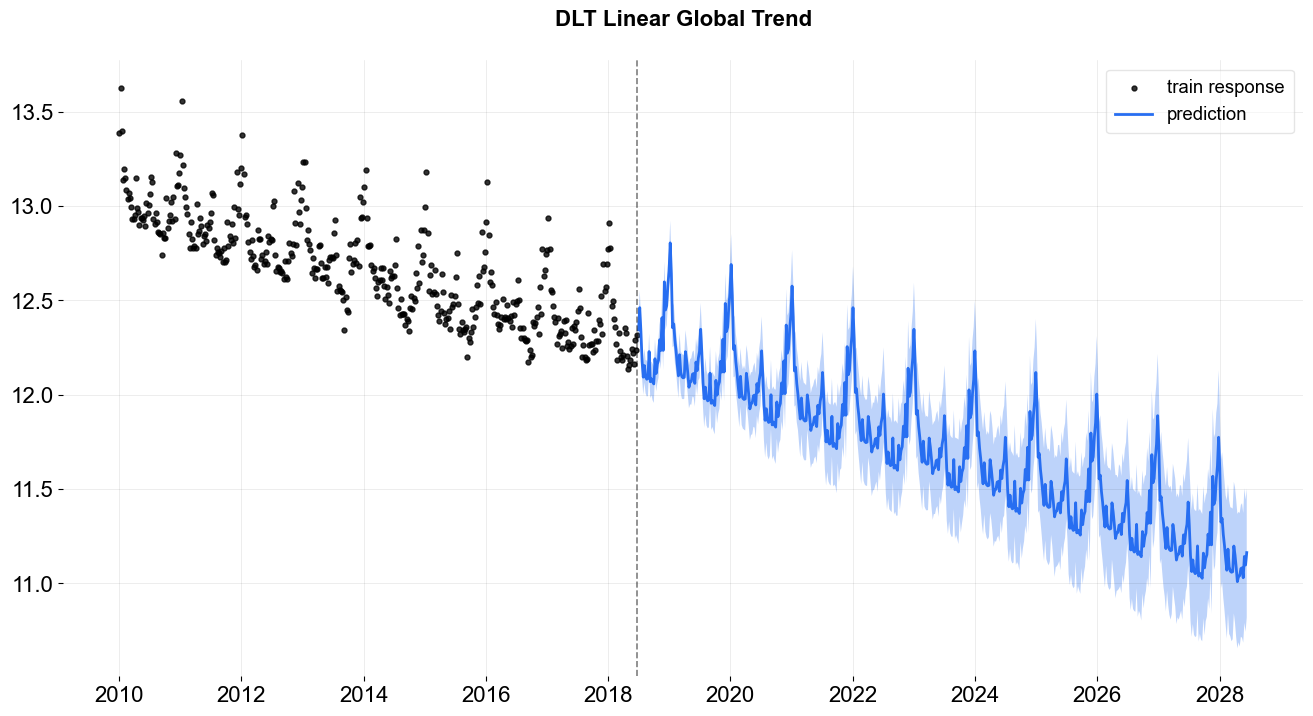

CPU times: user 562 ms, sys: 1.34 s, total: 1.91 s
Wall time: 460 ms


In [4]:
%%time

dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seasonality=52,
    seed=8888,
    global_trend_option='linear',
    # for prediction uncertainty
    n_bootstrap_draws=1000,
)

dlt.fit(df)
test_df = dlt.make_future_df(periods=52 * 10)
predicted_df = dlt.predict(test_df)
_ = plot_predicted_data(df, predicted_df, date_col, response_col,  title='DLT Linear Global Trend')

In [5]:
dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    seasonality=52,
    seed=8888,
    global_trend_option='linear',
    # for prediction uncertainty
    n_bootstrap_draws=1000,
)

dlt.fit(df, point_method="mean")

15:58:02 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
15:58:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:58:05 - cmdstanpy - INFO - CmdStan done processing.


One can use `.get_posterior_samples()` to extract the samples for all sampling parameters.

In [6]:
dlt.get_posterior_samples().keys()

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'gt_sum', 'gb', 'gl', 'loglk'])

15:58:05 - cmdstanpy - INFO - Chain [1] start processing
15:58:05 - cmdstanpy - INFO - Chain [1] done processing


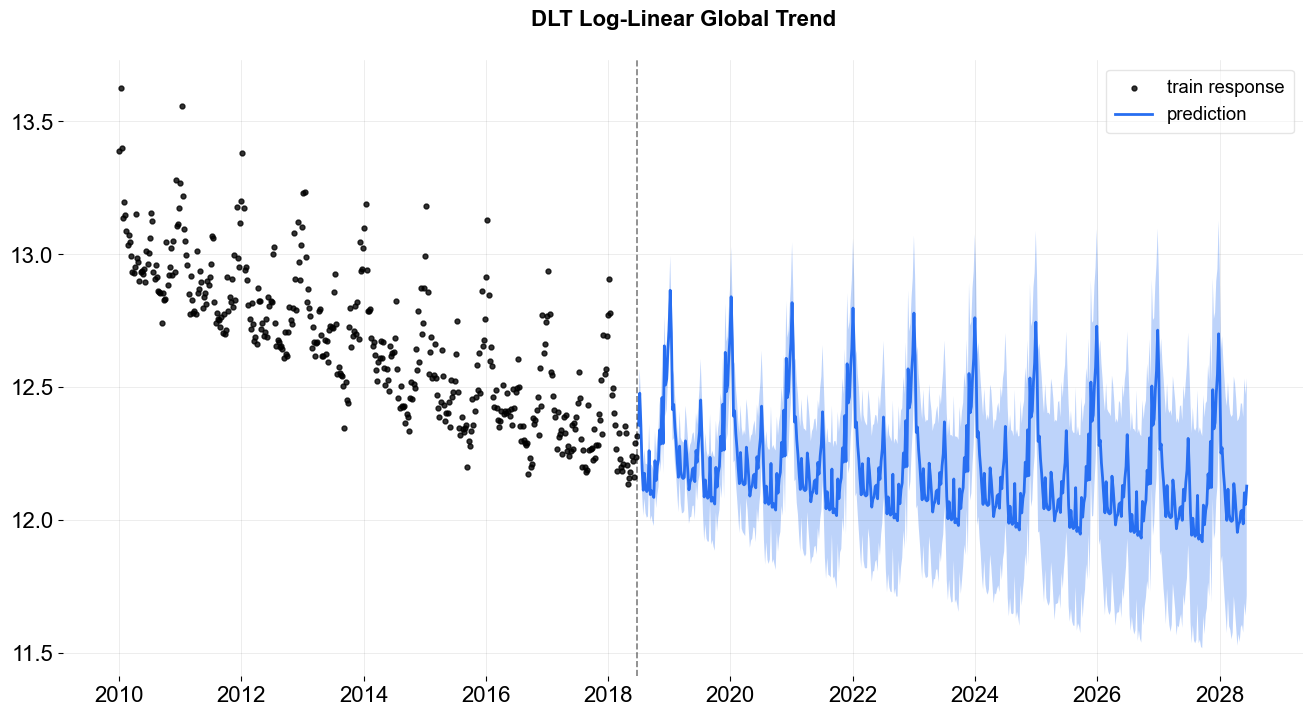

CPU times: user 605 ms, sys: 1.38 s, total: 1.98 s
Wall time: 507 ms


In [7]:
%%time
# log-linear global trend
dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    estimator='stan-map',
    seed=8888,
    global_trend_option='loglinear',
    # for prediction uncertainty
    n_bootstrap_draws=1000,
)

dlt.fit(df)
# re-use the test_df generated above
predicted_df = dlt.predict(test_df)
_ = plot_predicted_data(df, predicted_df, date_col, response_col,  title='DLT Log-Linear Global Trend')

In logistic trend, users need to specify the args `global_floor` and `global_cap`. These args are with default `0` and `1`.

### logistic global trend

15:58:06 - cmdstanpy - INFO - Chain [1] start processing
15:58:06 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 286 ms, sys: 167 ms, total: 453 ms
Wall time: 372 ms


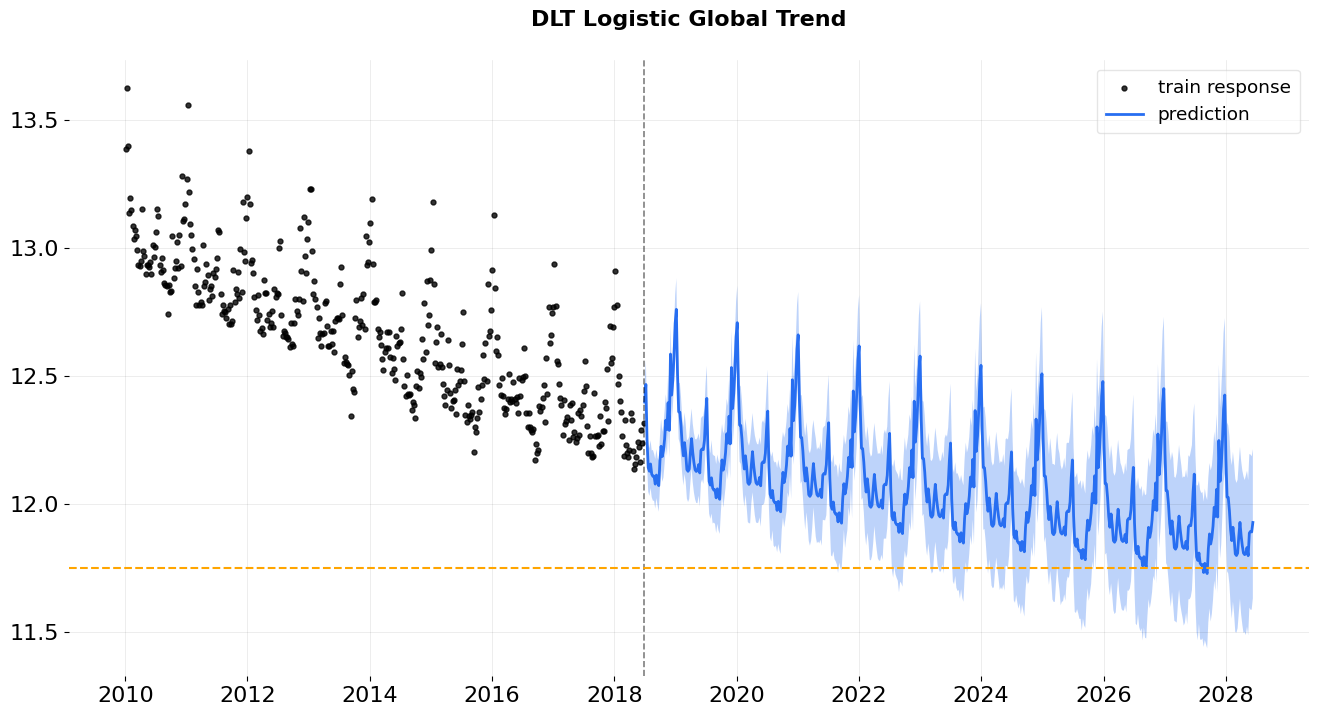

In [8]:
%%time

dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seasonality=52,
    seed=8888,
    global_trend_option='logistic',
    global_cap=9999,
    global_floor=11.75,
    damped_factor=0.1,
    # for prediction uncertainty
    n_bootstrap_draws=1000,
)

dlt.fit(df)
predicted_df = dlt.predict(test_df)
ax = plot_predicted_data(df, predicted_df, date_col, response_col, 
                         title='DLT Logistic Global Trend', is_visible=False);
ax.axhline(y=11.75, linestyle='--', color='orange')
ax.figure

Note: Theoretically, the trend is bounded by the `global_floor` and `global_cap`. However, because of seasonality and regression, the predictions can still be slightly lower than the floor or higher than the cap.

### flat trend

15:58:06 - cmdstanpy - INFO - Chain [1] start processing
15:58:06 - cmdstanpy - INFO - Chain [1] done processing


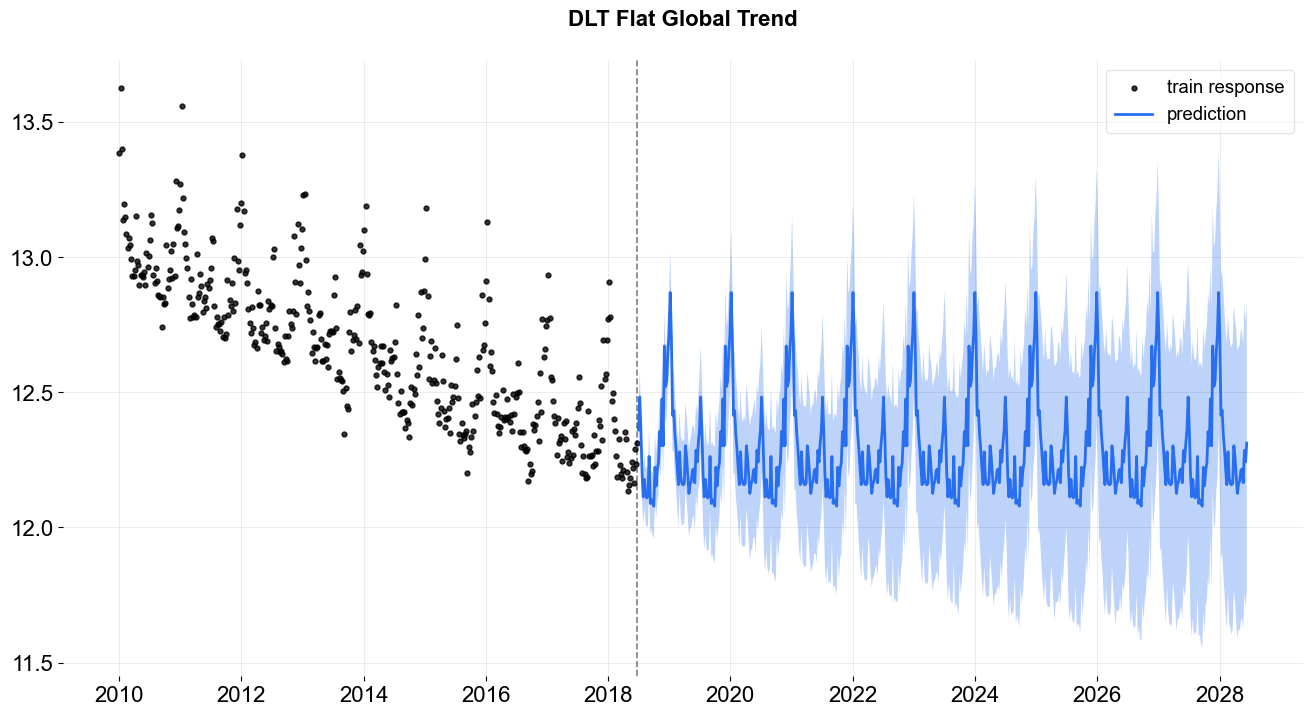

CPU times: user 609 ms, sys: 1.5 s, total: 2.11 s
Wall time: 497 ms


In [9]:
%%time

dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seasonality=52,
    seed=8888,
    global_trend_option='flat',
    # for prediction uncertainty
    n_bootstrap_draws=1000,
)

dlt.fit(df)
predicted_df = dlt.predict(test_df)
_ = plot_predicted_data(df, predicted_df, date_col, response_col,  title='DLT Flat Global Trend')

## Regression

You can also add regressors into the model by specifying `regressor_col`. This serves the purpose of nowcasting or forecasting when exogenous regressors are known such as events and holidays. Without losing generality, the interface is set to be

$$\beta_j ~\sim \mathcal{N}(\mu_j, \sigma_j^2)$$

where $\mu_j = 0$  and $\sigma_j = 1$ by default as a non-informative prior. These two parameters are set by the arguments `regressor_beta_prior` and `regressor_sigma_prior` as a list.  For example,

15:58:07 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
15:58:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:58:09 - cmdstanpy - INFO - CmdStan done processing.


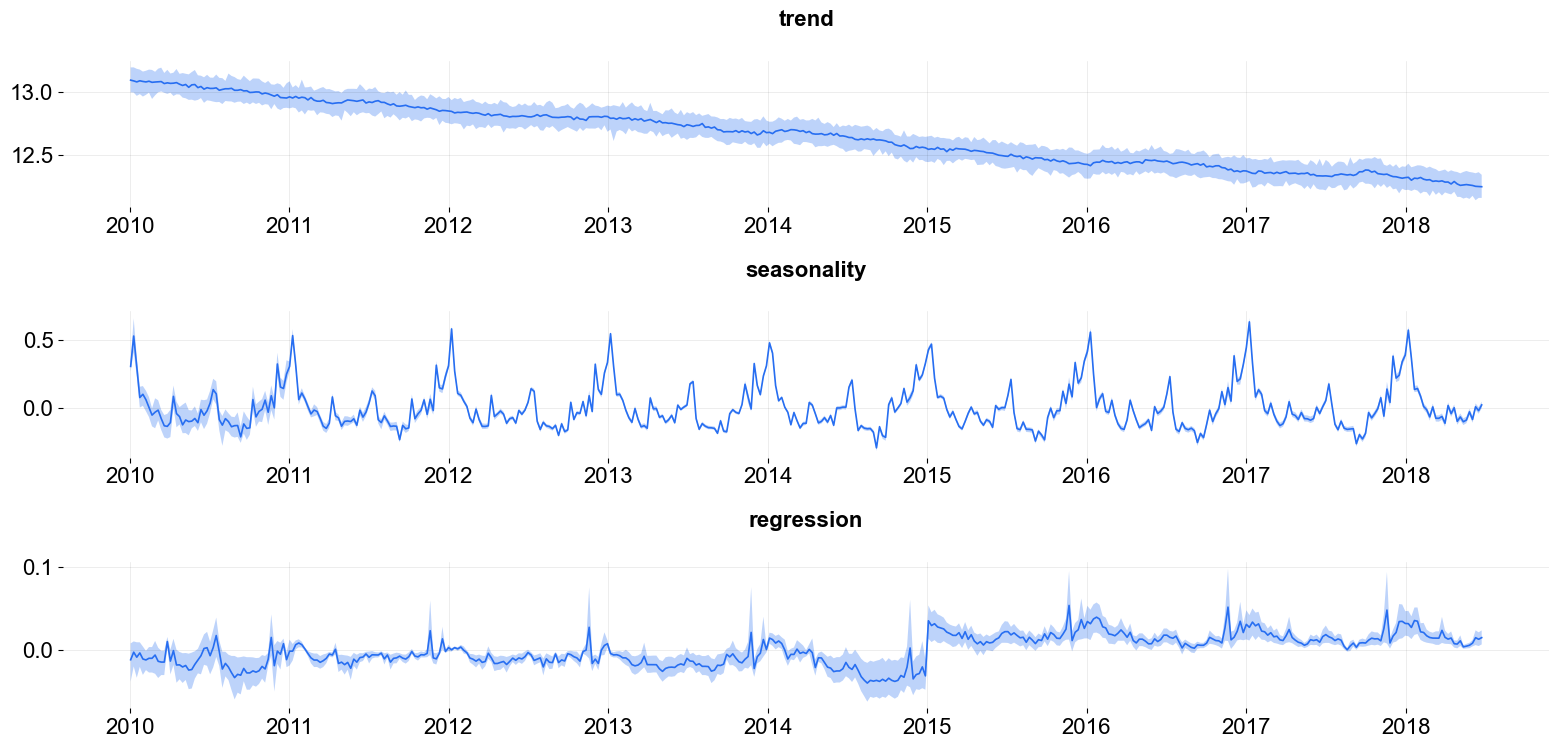

In [10]:
dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    seed=8888,
    seasonality=52,
    regressor_col=['trend.unemploy', 'trend.filling'],
    regressor_beta_prior=[0.1, 0.3],
    regressor_sigma_prior=[0.5, 2.0],
)

dlt.fit(df)
predicted_df = dlt.predict(df, decompose=True)
plot_predicted_components(predicted_df, date_col);

One can also use `.get_regression_coefs` to extract the regression coefficients along with the confidence interval when posterior samples are available. The default lower and upper limits are set to be .05 and .95.

In [11]:
dlt.get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,trend.unemploy,Regular,0.051256,0.020141,0.080398,1.00,0.00
1,trend.filling,Regular,0.074210,0.010242,0.146073,0.97,0.03


There are much more configurations on regression such as the regressors sign and penalty type.  They will be discussed in subsequent sections.

### High Dimensional and  Fourier Series Regression

In case of high dimensional regression, users can consider fixing the smoothness with a relatively small levels smoothing values e.g. setting `level_sm_input=0.01`. This is particularly useful in modeling higher frequency time-series such as daily and hourly data using regression on Fourier series. Check out the `examples/` folder for more details.